# Search
In this notebook we'll use a trained network to search for a configuration of input pins to produce the behaviour of some logical gate. 

In [1]:
from __future__ import division, print_function, unicode_literals, absolute_import

import numpy as np
import brainstorm as bs
import h5py
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import product

%matplotlib inline

No module named pycuda


In [2]:
def generate_in_out(function, n=2, inp_values=(-1., 1.), inp_idxs=(0, 1), outp_values=(-1., 1.)):
    """
    Generate list of desired inputs and outputs.
    :param n: number of points per input combination (should be even)
    :param function: the binary logical function to use
    :param inp_values: values passed to the input pins that represent True and False
    :param outp_values: values expected from the output pin that represent True and False
    :param inp_idxs: indices of the input pins
    """
    values = np.linspace(inp_values[0], inp_values[1], n)
    truthy_values = np.zeros(n)
    truthy_values[n//2:] = 1.0
    inputs = list(product(values, values))
    outputs = [outp_values[function(a, b)] for a, b in product(truthy_values, truthy_values)]
    return inputs, outputs

In [3]:
def generate_random_inputs(inputs, outputs, inp_idxs=(0, 1), std=0.1):
    """Generate inputs and outputs with a random configuration"""
    x = np.zeros((1, len(inputs), 8))
    x[0, :, :] = np.random.randn(1, 8)*std
    t = np.zeros((1, len(inputs), 1))
    for i, ((in1, in2), o) in enumerate(zip(inputs, outputs)):
        x[0, i, inp_idxs[0]] = in1
        x[0, i, inp_idxs[1]] = in2
        t[0, i, 0] = o 
    return x, t

In [4]:
def find_cfg(net, x, t, repetitions=1000, idxs=[0, 1], lr=0.003, verbosity=10):
    """Do SGD on the inputs while ignoring the given indices"""
    learning_rate = lr
    for i in range(repetitions):
        net.provide_external_data(dict(input_data=x, targets=t))
        net.forward_pass()
        if verbosity and (i+1) % (repetitions/verbosity) == 0:
            print(net.get_loss_value())
            pass
            
        net.backward_pass()
        d = net.buffer.backward.InputLayer.outputs.input_data
        d = d.sum(axis=1)
        d[0, idxs] = 0
        x -= learning_rate * d.reshape(1, 1, 8)
    return x, net.get_loss_value()

## Get the network

In [5]:
from train_net import ex, build_network
run = ex._create_run_for_command("print_config", config_updates={}, named_configs_to_use={})
weights = np.load('best_weights.npy')
net = build_network()
net.buffer.forward.parameters[:] = weights

# Search for configurations

## AND Gate
First we need to generate the input data that we want to start with.

It'll have one entry for each entry of the value-grid of two inputs that we want to match.
The values for the configuration pins will be random, but the input pins and the targets will be fixed. 

In [6]:
n = 2   # input grid resolution (should be an even number usually 2 or 4)
inp_idxs = (0, 1)  # indices of the two input pins
inp_values = (0, 1.)  # values to consider OFF and ON as inputs respectively
outp_values = (0, 1.)  # values to consider OFF and ON as outputs respectively
logical_func = np.logical_and  # the logical function to use

inputs, outputs = generate_in_out(logical_func, n=n, inp_values=inp_values, 
                                  inp_idxs=inp_idxs, outp_values=outp_values)

Now we'll search for good values for the configuration pins, keeping the input pins fixed and trying to match the target outputs. We do this in two steps:

  1. randomly generate many starting points. Each one is only improved a bit
  2. take the best starting point and optimize the shit out of it

In [9]:
nr_starting_points = 300
epochs_for_start = 100
epochs_for_final = 10000
learning_rate_start = .1
learning_rate_final = .01

best_x = None
best_loss = float('inf')
print("Randomly searching for a good starting point...")
for i in range(nr_starting_points):
    x, t = generate_random_inputs(inputs, outputs, inp_idxs=inp_idxs)
    x, loss = find_cfg(net, x, t, epochs_for_start, lr=learning_rate_start, verbosity=0)
    if loss < best_loss:
        best_x = x
        best_loss = loss
        print("  New best result from iteration {}: {}".format(i, best_loss))

print('Refining...')
x, loss = find_cfg(net, best_x, t, epochs_for_final, lr=learning_rate_final, verbosity=5)
print('\nBest Result:', loss)

Randomly searching for a good starting point...
  New best result from iteration 0: 0.124624960124
  New best result from iteration 2: 0.122709199786
  New best result from iteration 6: 0.119696319103
  New best result from iteration 20: 0.103247463703
  New best result from iteration 82: 0.0313341133296
Refining...
0.00330948270857
0.00258344272152
0.00245240959339
0.00244843191467
0.00244860351086

Best Result: 0.00244860351086


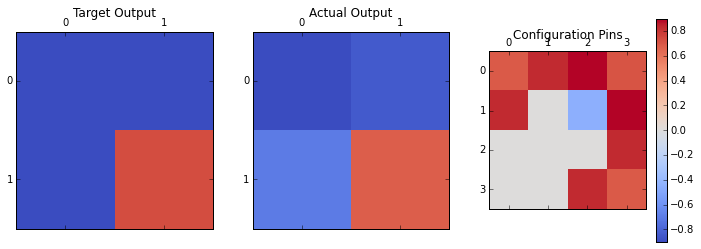

In [11]:
net.provide_external_data(dict(input_data=x, targets=t))
net.forward_pass()
out = net.buffer.forward.SquaredDifferenceLayer.inputs.inputs_1.flatten()
config_vis = np.array([
    [4, 5, 6, 7],
    [3, 0, 8, 6],
    [2, 0, 0, 5],
    [0, 1, 3, 4]]).flatten()

m = np.zeros(len(config_vis))
x_ = np.hstack(([0], x[0, 0].flatten()))
m[:] = x_[config_vis]
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
vmin, vmax = outp_values[0] * 1.1, outp_values[1] * 1.1

c = axes[0].matshow(t.reshape(n, n),vmin=vmin, vmax=vmax, cmap=cm.coolwarm)
c = axes[1].matshow(out.reshape(n, n),vmin=vmin, vmax=vmax, cmap=cm.coolwarm)

vrange = max(abs(m.min()), abs(m.max()))

c = axes[2].matshow(m.reshape(4, 4), vmin=-vrange, vmax=vrange, cmap=cm.coolwarm)
_ = fig.colorbar(c)

axes[0].set_title('Target Output')
axes[1].set_title('Actual Output')
axes[2].set_title('Configuration Pins')